# Naiwny klasyfikator bayesowski

Celem ćwiczenia jest zapoznanie się z technikami konstrukcji naiwnego klasywikatora bayesowskiego. 

Ćwiczenie oparte jest o artykuł z [linku](https://www.kaggle.com/prashant111/naive-bayes-classifier-in-python/notebook)

In [1]:
import warnings
import pandas as pd 
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix


warnings.filterwarnings('ignore')

Na początku proszę wczytać plik __data.csv__ używając jako separatora ',':

In [2]:
df = pd.read_csv("data.csv")
df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Następnie sprawdź które z kolumn zawierają dane tekstowe lub liczbowe. W tym celu sprawdź wartość  argumentu *dtype* z odpowiednim warunkiem:

In [3]:
categorical = [var for var in df.columns if df[var].dtype == 'O']
df[categorical].head()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K


In [4]:
numerical = [var for var in df.columns if df[var].dtype != 'O']
df[numerical].head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
0,39,77516,13,2174,0,40
1,50,83311,13,0,0,13
2,38,215646,9,0,0,40
3,53,234721,7,0,0,40
4,28,338409,13,0,0,40


Sprawdź czy dane w kolumnach nie zawierają braków a jeżeli tak uzupełnij je według znanych Ci metod:

In [5]:
df[categorical].isnull().sum()

workclass         0
education         0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
native_country    0
income            0
dtype: int64

*Zmienne kategorialne nie przyjmują wartości NaN podanych jawnie.*

In [6]:
for var in categorical:
    print(f"Zmienna: {var}, wartości: {df[var].unique()}")

Zmienna: workclass, wartości: [' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']
Zmienna: education, wartości: [' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']
Zmienna: marital_status, wartości: [' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']
Zmienna: occupation, wartości: [' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']
Zmienna: relationship, wartości: [' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-relative']
Zmienna: race, wartości: [' White' ' Black' ' Asian-Pac-Islander

*Kolumny workclass, occupation i native_country zawierają niepełne dane w postaci znaków zapytania poprzedzonych spacją - " ?". Dokonajmy ich zamiany na jawne wartości NaN.*

In [7]:
for col in ["workclass", "occupation", "native_country"]:
    df[col].replace(" ?", np.NaN, inplace=True)
    
df[numerical].isnull().sum()

age               0
fnlwgt            0
education_num     0
capital_gain      0
capital_loss      0
hours_per_week    0
dtype: int64

*Kolumny odpowiadające zmiennym numerycznym nie zawierają niepełnych danych.*

Na przygotowanych danych przeprowadź proces tworzenia zbiorów uczących i testowych, tak by klasyfikator rozpoznawał do której z grup w kolumnie 'income' należy opisywana osoba


### Zmienna "income"

In [8]:
# Wybieramy zmienną "income" jako zmienną zależną
X = df.drop(["income"], axis=1)
y = df["income"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Wypełniamy brakujące dane najczęściej występującymi wartościami ze zbioru uczącego
for df_X in [X_train, X_test]:
    for col in ["workclass", "occupation", "native_country"]:
        df_X[col].fillna(X_train[col].mode()[0], inplace=True)

Przy pomocy biblioteki [category_encoders](https://contrib.scikit-learn.org/category_encoders/) przeprowadź proces kodowania zmiennych tektowych z pozostałych kategorii na wartości liczbowe:

In [9]:
# Przeprowadzamy kodowanie
encoder = ce.OneHotEncoder()
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

# Przeprowadzamy skalowanie
cols = X_train.columns
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

In [10]:
X_train.head()

,age,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,fnlwgt,...,native_country_32,native_country_33,native_country_34,native_country_35,native_country_36,native_country_37,native_country_38,native_country_39,native_country_40,native_country_41
0,0.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.058906,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.50,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.578076,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.080425,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.270650,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.210240,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
X_test.head()

,age,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,fnlwgt,...,native_country_32,native_country_33,native_country_34,native_country_35,native_country_36,native_country_37,native_country_38,native_country_39,native_country_40,native_country_41
0,-0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.006571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.323136,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.656361,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.253496,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.042564,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Używając [GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) przeprowadź klasyfikację daych ze zbiorów testowych i treningowych. Podaj dokładnosć modelu i macierz błędu wraz z jej wykresem i interpretacją.

In [12]:
# Inicjalizacja naiwnego klasyfikatora bayesowskiego
gnb = GaussianNB()

# Klasyfikacja
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

# Dokładności
print(f"Dokładność zbioru uczącego: {round(gnb.score(X_train, y_train), 4) * 100}%")
print(f"Dokładność zbioru testowego, czyli dokładność modelu: {round(gnb.score(X_test, y_test), 4) * 100}%")
vals = list(y_test.value_counts())
print(f"Dokładność wybierania najczęstszej wartości: {round(max(vals) / sum(vals), 4) * 100}%")

Dokładność zbioru uczącego: 80.67%
Dokładność zbioru testowego, czyli dokładność modelu: 80.83%
Dokładność wybierania najczęstszej wartości: 75.82%


*Dokładności są wysokie, zatem można uznać, że nasz naiwny klasyfikator bayesowski będzie klasyfikował z zadowalającą efektywnością.*

Tablica pomyłek:
[[5999 1408]
 [ 465 1897]]

Dokładność klasyfikacji: 80.83%


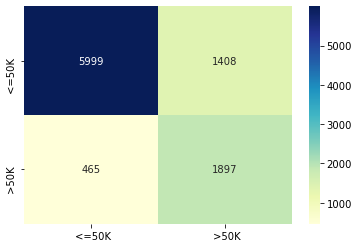

In [13]:
cm = confusion_matrix(y_test, y_pred)
print(f"Tablica pomyłek:\n{cm}\n")

diag_sum = 0
mat_sum = 0

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i == j:
            diag_sum += cm[i, j]
            
        mat_sum += cm[i, j]

print(f"Dokładność klasyfikacji: {round(diag_sum / mat_sum, 4) * 100}%")

cm_cols = list(y_test.unique())
cm_matrix = pd.DataFrame(data=cm, columns=cm_cols, index=cm_cols)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.show()

*Tablica pomyłek przedstawia nam, jakiej klasy jest dany obiekt oraz jaki wynik dała jego klasyfikacja.*

*Dokładność klasyfikacji to lekko ponad 80%, przez co można uznać nasz model za poprawny, aczkolwiek niepokojąca jest tendencja modelu do klasyfikacji obiektu klasy "<=50K" jako obiektu klasy ">50K", która zachodzi niemalże tak często jak poprawna klasyfikacja obiektu klasy ">50K".*

Przprowadź uczenie klasyfikatora dla kolumn *race* i *native_country*. Podaj dokładnosć modeli i macierze błędu wraz z ich wykresami i interpretacją. Przedstaw wnioski od czego zależą otrzymane wyniki

### Zmienna "race"

In [14]:
# Wybieramy zmienną "race" jako zmienną zależną
X = df.drop(["race"], axis=1)
y = df["race"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Wypełniamy brakujące dane najczęściej występującymi wartościami ze zbioru uczącego
for df_X in [X_train, X_test]:
    for col in ["workclass", "occupation", "native_country"]:
        df_X[col].fillna(X_train[col].mode()[0], inplace=True)
        
# Przeprowadzamy kodowanie
encoder = ce.OneHotEncoder()
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

# Przeprowadzamy skalowanie
cols = X_train.columns
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

In [15]:
X_train.head()

,age,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,fnlwgt,...,native_country_34,native_country_35,native_country_36,native_country_37,native_country_38,native_country_39,native_country_40,native_country_41,income_1,income_2
0,0.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.058906,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0
1,0.50,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.578076,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.080425,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0
3,-0.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.270650,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.210240,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
X_test.head()

,age,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,fnlwgt,...,native_country_34,native_country_35,native_country_36,native_country_37,native_country_38,native_country_39,native_country_40,native_country_41,income_1,income_2
0,-0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.006571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.323136,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.656361,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.253496,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.042564,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0


In [17]:
# Inicjalizacja naiwnego klasyfikatora bayesowskiego
gnb = GaussianNB()

# Klasyfikacja
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

# Dokładności
print(f"Dokładność zbioru uczącego: {round(gnb.score(X_train, y_train), 4) * 100}%")
print(f"Dokładność zbioru testowego, czyli dokładność modelu: {round(gnb.score(X_test, y_test), 4) * 100}%")
vals = list(y_test.value_counts())
print(f"Dokładność wybierania najczęstszej wartości: {round(max(vals) / sum(vals), 4) * 100}%")

Dokładność zbioru uczącego: 67.63%
Dokładność zbioru testowego, czyli dokładność modelu: 67.21000000000001%
Dokładność wybierania najczęstszej wartości: 85.86%


*Dokładności są stosunkowo wysokie, zatem można uznać, że nasz naiwny klasyfikator bayesowski będzie klasyfikował z zadowalającą efektywnością.*

Tablica pomyłek:
[[   6    0   27    2   45]
 [   5  163   40    5  105]
 [  20    4  476    7  404]
 [   1    3   14   21   33]
 [ 164   50 2036  238 5900]]

Dokładność klasyfikacji: 67.21000000000001%


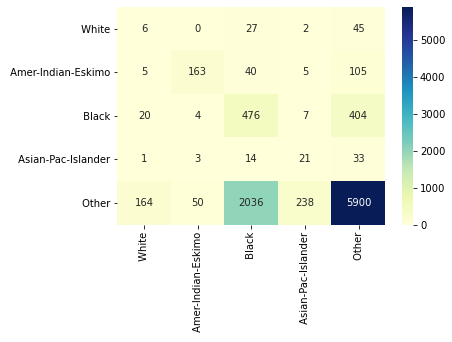

In [18]:
cm = confusion_matrix(y_test, y_pred)
print(f"Tablica pomyłek:\n{cm}\n")

diag_sum = 0
mat_sum = 0

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i == j:
            diag_sum += cm[i, j]
            
        mat_sum += cm[i, j]

print(f"Dokładność klasyfikacji: {round(diag_sum / mat_sum, 4) * 100}%")

cm_cols = list(y_test.unique())
cm_matrix = pd.DataFrame(data=cm, columns=cm_cols, index=cm_cols)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.show()

*Dokładność klasyfikacji to 67%, co jest dość zadowalającym wynikiem, ale znacznie gorszym niż w poprzednim podpunkcie. Wady tego modelu widać w tablicy pomyłek.*

*Zwróćmy uwagę na elementy na przekątnej. Jedyna wysoka wartość występuje dla klasy "Other", zatem model rzadko poprawnie klasyfikuje, że dany obiekt jest rzeczywiście obiektem jego faktycznej klasy. Model potrafi dobrze klasyfikować klasę "Other", gdyż jest to klasa o szeroko pojętych cechach, bowiem należą do niej wszystkie obiekty, które nie kwalifikują się do żadnej z pozostałych klas. W praktyce informacja o tym, że obiekt należy do klasy "Other", niewiele nam daje.*

*Warto również zauważyć, że za obiekt klasy "Black" model częściej uznaje obiekt klasy "Other" niż faktyczny obiekt klasy "Black". Może to wynikać z faktu, że klasa "Black" ma mało cech wspólnych z pozostałymi klasami i dlatego czasem obiekt klasy "Black" jest mylnie określany jako obiekt klasy "Other".*

### Zmienna "native_country"

In [19]:
# Usuwamy rekordy, dla których pojawia się wartość NaN w kolumnie zmiennej zależnej, czyli "native_country"
cleaned_data = df[df["native_country"].notna()]
X = cleaned_data.drop(["native_country"], axis=1)
y = cleaned_data["native_country"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Wypełniamy brakujące dane najczęściej występującymi wartościami ze zbioru uczącego
for df_X in [X_train, X_test]:
    for col in ["workclass", "occupation"]:
        df_X[col].fillna(X_train[col].mode()[0], inplace=True)
        
# Przeprowadzamy kodowanie
encoder = ce.OneHotEncoder()
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

# Przeprowadzamy skalowanie
cols = X_train.columns
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

In [20]:
X_train.head()

,age,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,fnlwgt,...,race_3,race_4,race_5,sex_1,sex_2,capital_gain,capital_loss,hours_per_week,income_1,income_2
0,-0.25,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.740932,...,0.0,0.0,0.0,0.0,0.0,4650.0,0.0,0.0,0.0,0.0
1,-0.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.051992,...,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-5.6,0.0,0.0
2,-0.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.024220,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
3,0.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.030581,...,1.0,0.0,0.0,-1.0,1.0,0.0,0.0,-3.2,0.0,0.0
4,0.10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.407526,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
X_test.head()

,age,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,fnlwgt,...,race_3,race_4,race_5,sex_1,sex_2,capital_gain,capital_loss,hours_per_week,income_1,income_2
0,0.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.321172,...,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,2.0,0.0,0.0
1,0.75,0.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.057204,...,0.0,0.0,0.0,0.0,0.0,0.0,2051.0,0.0,0.0,0.0
2,-0.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.173052,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.20,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.221804,...,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-5.0,-1.0,1.0
4,0.45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.173656,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Inicjalizacja naiwnego klasyfikatora bayesowskiego
gnb = GaussianNB()

# Klasyfikacja
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

# Dokładności
print(f"Dokładność zbioru uczącego: {round(gnb.score(X_train, y_train), 4) * 100}%")
print(f"Dokładność zbioru testowego, czyli dokładność modelu: {round(gnb.score(X_test, y_test), 4) * 100}%")
vals = list(y_test.value_counts())
print(f"Dokładność wybierania najczęstszej wartości: {round(max(vals) / sum(vals), 4) * 100}%")

Dokładność zbioru uczącego: 3.4299999999999997%
Dokładność zbioru testowego, czyli dokładność modelu: 3.15%
Dokładność wybierania najczęstszej wartości: 91.31%


*Dokładności są znacząco niskie, zatem można uznać, że nasz naiwny klasyfikator bayesowski nie będzie działał w żadnym stopniu poprawnie.*

Tablica pomyłek:
[[   0    0    0 ...    0    0    0]
 [   0    0    0 ...    2    0    8]
 [   0    0    2 ...    0    0    0]
 ...
 [   1    0    1 ...  260    2 2977]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    1]]

Dokładność klasyfikacji: 3.15%


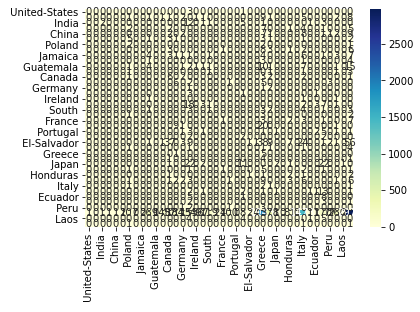

In [23]:
cm = confusion_matrix(y_test, y_pred)
print(f"Tablica pomyłek:\n{cm}\n")

diag_sum = 0
mat_sum = 0

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i == j:
            diag_sum += cm[i, j]
            
        mat_sum += cm[i, j]

print(f"Dokładność klasyfikacji: {round(diag_sum / mat_sum, 4) * 100}%")

cm_cols = list(y_test.unique())
cm_matrix = pd.DataFrame(data=cm, columns=cm_cols, index=cm_cols)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.show()

*Obiekt może należeć do jednej z 41 klas, przez co tablica pomyłek jest całkowicie nieczytelna. Można jednak wyciagnąć wnioski z dokładności oraz definicji analizowanego modelu.*

*Dokładność klasyfikacji to zaledwie 3.15%, co świadczy o bardzo słabym modelu.*

*Bezpośrednia przyczyna takiej efektywności modelu to zjawisko niedouczenia, które oznacza tyle, że nasz model jest zbyt prosty, aby mógł określić zależności między predyktorami a zmienną zależną. Wtedy predykcje modelu są wręcz przypadkowe. Powodem wystąpienia zjawiska niedouczenia jest zbyt duża liczba klas.*

*Aby model dobrze rozpoznawał dany obiekt przy takiej liczbie klas, należałoby dodać do niego więcej predyktorów. Jednakże nie jest to podejście bez skazy, gdyż jeśli przesadzimy, to może wystąpić zjawisko przeuczenia - model staje się zbyt skomplikowany jak na stosunkowo prosty problem. Konsekwencją zjawiska przeuczenia jest wykrywanie pozornych prawidłowości.*